# Miniscope to OpenEphys Data Alignment
This notebook helps align all frames recorded by a UCLA Miniscope to times in the corresonding OpenEphys file.  

Assumptions:
1) All OpenEphys recording .dat files have been concatenated into one file and their corresponding `timestamps.npy` files reside in subfolders of the parent directory where the combined .dat and .eeg files reside.
2) Likewise, all Miniscope files have been effectively concatenated and processed in Minian, and their corresponding `timeStamps.csv` files reside in subfolders of the parent directory. Corrupted videos are all noted in "corrupted_videos.csv" files located in each miniscope recording folder. Low illumination frames have also been identified in the Minian workflow and saved to the `good_frames_bool.npy` file in the `minian folder.
3) The miniscope sends a TTL to OpenEphys for each frame captured. (Exception is the first frame of each miniscope recording which is usually in the buffer before hitting record and thus doesn't have a TTL).

Saves a Pandas dataframe with miniscope timestamps and corresponding TTL timestamps in the combined file, along with corrupt frames, low illumination frames, and buffered frames (with no TTL) noted.  

IMPORTANT NOTE: Watch out for any warnings about start time having "second precision" when creating the `sync_df` DataFrame below, this will percolate through to all synchronized devices.

## Import code

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy/'])  # Add path to NeuroPy repository here
sys.path.extend(['/data/GitHub/NeuroPy/'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
import neuropy.io.openephysio as oeio
from neuropy.core.epoch import Epoch


## Import session data and load in all OpenEphys and Miniscope timestamps

In [2]:
dir_use = Path("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")
sess = core.ProcessData(dir_use)

# Create sync_df to ID start and end of each recording in concatenated .eeg file
sync_df = oeio.create_sync_df(dir_use)

# Get absolute time from start of first recording
sync_df['Tabs from start (s)'] = (sync_df['Datetime'] - sync_df['Datetime'].iloc[0]).dt.total_seconds()
sync_df

start time = 2022-02-17 10:33:51.810584-05:00
start time = 2022-02-17 10:45:04.949076-05:00
start time = 2022-02-17 11:44:40.100407-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Tabs from start (s)
0,0,2022-02-17 10:33:51.810584-05:00,start,0,0.000000,0,0.0000,0.000000
1,0,2022-02-17 10:39:00.589217333-05:00,stop,9263359,308.778633,385973,308.7784,308.778633
2,1,2022-02-17 10:45:04.949076-05:00,start,9263360,308.778667,385974,308.7792,673.138492
3,1,2022-02-17 11:43:54.805042667-05:00,stop,115159039,3838.634633,4798293,3838.6344,4202.994459
4,2,2022-02-17 11:44:40.100407-05:00,start,115159040,3838.634667,4798294,3838.6352,4248.289823
5,2,2022-02-17 13:24:56.424640333-05:00,stop,295648767,9854.958900,12318698,9854.9584,10264.614056


In [3]:
# Load in ALL TTLs
ttl_chan_use = 1  # TTL channel where OpenEphys inputs go
ttl_df = oeio.load_all_ttl_events(dir_use)
ttl_df = ttl_df[ttl_df.channel_states.abs() == ttl_chan_use]
ttl_df.head(5)

,channel_states,timestamps,datetimes,sample_number,event_name,Recording
0,-1,82316,2022-02-17 10:33:54.554450667-05:00,82316,,0
1,1,84406,2022-02-17 10:33:54.624117333-05:00,84406,,0
2,-1,86359,2022-02-17 10:33:54.689217333-05:00,86359,,0
3,1,88384,2022-02-17 10:33:54.756717333-05:00,88384,,0
4,-1,90431,2022-02-17 10:33:54.824950667-05:00,90431,,0


In [4]:
# Load in miniscope timestamps
MIO = MiniscopeIO(dir_use)
MIO.load_all_timestamps(tz="America/Detroit", return_corrupt_times=True)

MIO.times_all

,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Recording,Corrupt
0,0,-68,0,2022-02-17 10:33:54.411000-05:00,0,False
1,1,2,0,2022-02-17 10:33:54.481000-05:00,0,False
2,2,87,0,2022-02-17 10:33:54.566000-05:00,0,False
3,3,136,0,2022-02-17 10:33:54.615000-05:00,0,False
4,4,202,0,2022-02-17 10:33:54.681000-05:00,0,False
...,...,...,...,...,...,...
8014,8014,539955,0,2022-02-17 13:24:41.579000-05:00,13,False
8015,8015,540022,0,2022-02-17 13:24:41.646000-05:00,13,False
8016,8016,540090,0,2022-02-17 13:24:41.714000-05:00,13,False
8017,8017,540157,0,2022-02-17 13:24:41.781000-05:00,13,False


In [5]:
# Get start times of each miniscope video
ms_start_df = MIO.get_rec_starts()
ms_start_df

,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Recording,Corrupt
1,1,2,0,2022-02-17 10:33:54.481000-05:00,0,False
1,1,28,0,2022-02-17 10:45:12.624000-05:00,1,False
1,1,14,0,2022-02-17 11:16:16.820000-05:00,2,False
1,1,4,0,2022-02-17 11:31:25.548000-05:00,3,False
1,1,11,0,2022-02-17 11:44:46.204000-05:00,4,False
1,1,16,0,2022-02-17 11:47:31.009000-05:00,5,False
1,1,14,0,2022-02-17 11:57:46.644000-05:00,6,False
1,1,30,0,2022-02-17 12:08:01.672000-05:00,7,False
1,1,29,0,2022-02-17 12:09:32.295000-05:00,8,False
1,1,49,0,2022-02-17 12:20:03.696000-05:00,9,False


In [6]:
## Test code for below!

# # Identify start TTL!
# buffer_sec = 1 # time buffer in seconds for start / stop
# ms_sr = 15
# oe_sr = 30000
# buffer_td = pd.Timedelta(buffer_sec, unit="sec")
# ms_rec_num = 1

# # First grab timestamp for miniscope recording start
# # ms_start_ts = ms_start_df.iloc[0]["Timestamps"]
# ms_start_ts = ms_start_df[ms_start_df.Recording == ms_rec_num].iloc[0]["Timestamps"]

# # Next ID ephys recording start
# rec_bool = ((sync_df[sync_df.Condition == "start"]["Datetime"] - buffer_td)  < ms_start_ts).values & ((sync_df[sync_df.Condition == "stop"]["Datetime"] + buffer_td) > ms_start_ts).values
# oe_rec_num_use = sync_df[sync_df.Condition == "start"][rec_bool]["Recording"].iloc[0]
# oe_rec_num_use

# # Grab ttls from specific recording
# ttl_rec = ttl_df[ttl_df.Recording == oe_rec_num_use]

# start_ind = np.where((ttl_rec["timestamps"].diff() > (buffer_sec * oe_sr)) |  np.isnan(ttl_rec["timestamps"].diff()))[0]
# assert len(start_ind) == 1, "multiple candidate start times found in OE TTLs, adjust buffers and try again"
# start_ttl = ttl_rec.iloc[start_ind[0]]

# # Print stuff to screen as sanity check
# print(f"MS start = {ms_start_ts}")
# print(f"Corresponding TTL time in OE = {start_ttl['datetimes']}")
# start_delta = start_ttl['datetimes'] - ms_start_ts 

# prior_oe_rec_start_dt = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["Datetime"]
# ms_start_dt = MIO.times_all[MIO.times_all.Recording == ms_rec_num]["Timestamps"]
# prior_oe_rec_start_comb_time = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["eeg_time"]
# ms_times_eeg_align = (ms_start_dt + start_delta - prior_oe_rec_start_dt).dt.total_seconds() + prior_oe_rec_start_comb_time
# ms_times_eeg_align


# # Need to chop any frames happening after OE recording stops!


## Align each Miniscope recording and its timestamps to Open Ephys TTLs

In [6]:
# Workhorse code to align each miniscope recording to each corresponding block of TTLs in OE

buffer_sec = 1 # time buffer in seconds for start / stop detection
oe_sr = sess.recinfo.dat_sampling_rate # OpenEphys sample rate
buffer_td = pd.Timedelta(buffer_sec, unit="sec")

ms_times_df = []
for ms_rec_num in ms_start_df.Recording.values:
# for ms_rec_num in [5]:
    
    # First grab timestamp for miniscope recording start
    ms_start_ts = ms_start_df[ms_start_df.Recording == ms_rec_num].iloc[0]["Timestamps"]
    
    # Next ID ephys recording start based on closest TTL to start
    rec_bool = ((sync_df[sync_df.Condition == "start"]["Datetime"] - buffer_td)  < ms_start_ts).values & ((sync_df[sync_df.Condition == "stop"]["Datetime"] + buffer_td) > ms_start_ts).values
    oe_rec_num_use = sync_df[sync_df.Condition == "start"][rec_bool]["Recording"].iloc[0]
    oe_rec_num_use
    
    # Grab ttls from specific recording
    ttl_rec = ttl_df[ttl_df.Recording == oe_rec_num_use]
    
    oe_start_inds = np.where((ttl_rec["timestamps"].diff() > (buffer_sec * oe_sr)) |  np.isnan(ttl_rec["timestamps"].diff()))[0]
    start_ind = oe_start_inds[np.where((ttl_rec.iloc[oe_start_inds]["datetimes"] - ms_start_ts).dt.total_seconds().abs() < buffer_sec)[0]]
    if len(start_ind) < 1:  # Align all timestamps roughly to start of oe recordings
        ms_rec_df = MIO.times_all[MIO.times_all.Recording == ms_rec_num]
        ms_times_eeg_align = pd.DataFrame((ms_rec_df.Timestamps - sync_df.iloc[0]["Datetime"]).dt.total_seconds())

        # Note that these frames don't have matching TTLS and have second precision
        ms_times_eeg_align["Matching_TTL"] = False
        ms_times_eeg_align["Precision"] = "s"
    else:
        assert len(start_ind) == 1, "multiple candidate start times found in OE TTLs, adjust buffers and try again"
        start_ttl = ttl_rec.iloc[start_ind[0]]
        
        # Print stuff to screen as sanity check
        # print(f"MS start = {ms_start_ts}")
        # print(f"Corresponding TTL time in OE = {start_ttl['datetimes']}")
    
        # Calculate delta between miniscope time start and ttl received in OE
        start_delta = start_ttl['datetimes'] - ms_start_ts 
        # print(f"start_delta_sec={start_delta.total_seconds()}")
    
        # Now adjust each timestamp in miniscope timestamps by start offset from OE TTL 
        prior_oe_rec_start_dt = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["Datetime"]
        ms_rec_df = MIO.times_all[MIO.times_all.Recording == ms_rec_num]
        prior_oe_rec_start_comb_time = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["eeg_time"]
        ms_times_eeg_align = pd.DataFrame((ms_rec_df["Timestamps"] + start_delta - prior_oe_rec_start_dt).dt.total_seconds() + prior_oe_rec_start_comb_time)
        ms_times_eeg_align["Matching_TTL"] = ms_rec_df["Time Stamp (ms)"] > 0
        ms_times_eeg_align["Precision"] = "TTL"  # TTL precision is ~ dat SampleRate
    
    # Save recording number, corrupt frame boolean, if frame was in the buffer before hitting record, and then shift
    # any pre-recording buffered frames to have negative indices
    ms_times_eeg_align["Recording"] = ms_rec_num
    ms_times_eeg_align["Corrupt"] = ms_rec_df["Corrupt"]
    ms_times_eeg_align["Pre_rec_buffer"] = ms_rec_df["Time Stamp (ms)"] < 0
    n_pre_buffer = (ms_rec_df["Time Stamp (ms)"] < 0).sum()
    ms_times_eeg_align = ms_times_eeg_align.set_index(ms_times_eeg_align.index - n_pre_buffer)
    
    ms_times_df.append(ms_times_eeg_align)

# Get output times of all miniscope timestamps now referenced to the eeg time.
ms_ts_align_df = pd.concat(ms_times_df, axis=0)
ms_ts_align_df.insert(1, "Recording", ms_ts_align_df.pop("Recording"))
ms_ts_align_df

,Timestamps,Recording,Corrupt,Pre_rec_buffer
-1,2.673867,0,False,True
0,2.743867,0,False,False
1,2.828867,0,False,False
2,2.877867,0,False,False
3,2.943867,0,False,False
...,...,...,...,...
8013,9840.188300,13,False,False
8014,9840.255300,13,False,False
8015,9840.323300,13,False,False
8016,9840.390300,13,False,False


## Construct recording epochs from Miniscope timestamps and OpenEphys TTLs for comparison

In [7]:
# Create a dataframe for the start and stop time of each recording in EEG time. 
ms_starts = ms_ts_align_df.loc[0]["Timestamps"]
ms_starts = ms_starts if ms_starts.shape == () else ms_starts.values
ms_stops = np.hstack((ms_ts_align_df[(ms_ts_align_df["Timestamps"].diff(-1) < - buffer_sec)]["Timestamps"].values, 
                       ms_ts_align_df.iloc[-1]["Timestamps"]))

ms_rec_epochs = Epoch(pd.DataFrame({"start": ms_starts, "stop": ms_stops, "label": "ms_rec_after_align"}))
ms_rec_epochs

14 epochs
Snippet: 
          start         stop               label
0     2.743867   302.843867  ms_rec_after_align
1   316.502633  2117.901633  ms_rec_after_align
2  2180.719633  3081.226633  ms_rec_after_align
3  3089.447600  3836.804600  ms_rec_after_align
4  3844.817567  3996.145567  ms_rec_after_align

In [8]:
# Construct time epochs of miniscope recordings from TTL series. Assumes delta between timestamps from TTLs > ttl_rec_thresh
ttl_rec_thresh = 1  # Any TTLs greater than this # seconds apart will be considered from a separate recording
rec_label = "miniscope_from_ttl"
sr_ttl = 30000

# Get absolute time from first recording start for each TTL - will chop out other isolated TTLs (noise) that occur
## Rule for start - diff = nan or diff > thresh
## Rule for stop: diff(-1) < -thresh
dt_ttl_sec = (ttl_df["datetimes"] - sync_df.iloc[0]["Datetime"]).dt.total_seconds()
rec_start_inds = np.where((dt_ttl_sec.diff() > ttl_rec_thresh) | np.isnan(dt_ttl_sec.diff()))[0]
rec_stop_inds = np.where((dt_ttl_sec.diff(-1) < -ttl_rec_thresh) | np.isnan(dt_ttl_sec.diff(-1)))[0]

# Interpolate start and stop back to combined recording time
rec_start_t_comb = np.interp(dt_ttl_sec.iloc[rec_start_inds].values, sync_df["Tabs from start (s)"], sync_df["eeg_time"])
rec_stop_t_abs = np.interp(dt_ttl_sec.iloc[rec_stop_inds].values, sync_df["Tabs from start (s)"], sync_df["eeg_time"])
# rec_stop_inds = np.hstack((rec_stop_inds, ttl_df.shape[0] - 1))

rec_epochs_from_ttl = Epoch(pd.DataFrame({"start": rec_start_t_comb, "stop": rec_stop_t_abs, "label": rec_label}))

rec_ttl_align_df = []
zero_length_bool = (rec_stop_inds - rec_start_inds) == 0  # Chop out any isolated TTLs
for idr, (start_ind, stop_ind) in enumerate(zip(rec_start_inds[~zero_length_bool], 
                                                rec_stop_inds[~zero_length_bool])):
    rec_ttl_times_use = np.interp(dt_ttl_sec.iloc[start_ind:stop_ind].values, sync_df["Tabs from start (s)"], sync_df["eeg_time"])
    rec_ttl_align_df.append(pd.DataFrame({"ttl_sec_from_eeg_start": rec_ttl_times_use, "Recording": idr}))
rec_ttl_align_df = pd.concat(rec_ttl_align_df, axis=0)

# print(rec_start_inds)
# print(rec_stop_inds)
rec_epochs_from_ttl

14 epochs
Snippet: 
          start         stop               label
0     2.743865   302.914604  miniscope_from_ttl
1   316.502632  2117.989574  miniscope_from_ttl
2  2180.719227  3081.294231  miniscope_from_ttl
3  3089.446996  3836.873134  miniscope_from_ttl
4  3844.817566  3996.215606  miniscope_from_ttl

## Sanity checks


Plot epochs created from both miniscope times and OE TTLs times to make sure they match.

<Axes: >

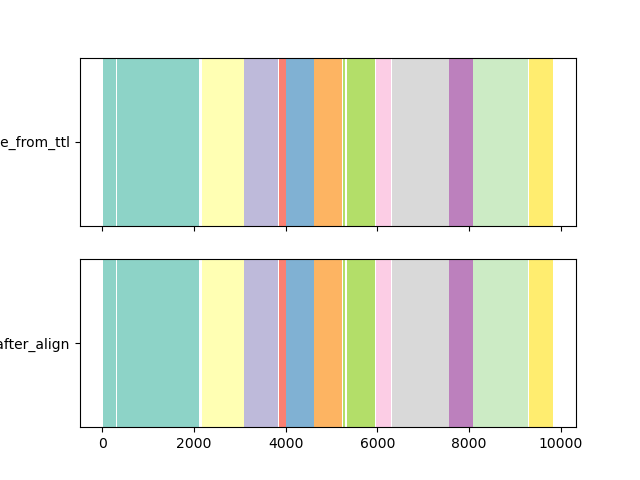

In [10]:
%matplotlib widget
import neuropy.plotting.epochs as plt_epochs
_, ax = plt.subplots(2, 1, sharex=True)
plt_epochs.plot_epochs(rec_epochs_from_ttl[rec_epochs_from_ttl.durations > 0], ax=ax[0])
plt_epochs.plot_epochs(ms_rec_epochs, ax=ax[1])

Print out # frames you expect and check to see if any don't match

In [11]:
# Total # frames in miniscope data after chucking data frames that were discarded due 
# to insufficient LED power (at recording onsets or when turning off the camera).
nuseable_frames = np.load(dir_use / "Miniscope_combined/minian/C.npy").shape[1]
print(f"{nuseable_frames} usable miniscope frames with sufficient LED power")

74308 usable miniscope frames with sufficient LED power


In [12]:
# total number frames including corrupt frames - good frames will be saved in final aligned timestamp file.
good_frames_bool = np.load(dir_use / "Miniscope_combined/minian/good_frames_bool.npy")
nnoncorrupt = good_frames_bool.shape[0]
print(f"{nnoncorrupt} non-corrupt frames")

143105 non-corrupt frames


In [13]:
# Now check # timestamps found, should match up with the above
nframes_total = ms_ts_align_df.shape[0]
nframes_not_corrupt = ms_ts_align_df[~ms_ts_align_df.Corrupt].shape[0]

print(f"{nframes_total} total miniscope timestamps (including corrupt frames).")
print(f"{nframes_not_corrupt} non-corrupt miniscope timestamps.")

143105 total miniscope timestamps (including corrupt frames).
143105 non-corrupt miniscope timestamps.


## Investigate dropped frames here - will vary for each session

Example here illustrates general procedure to identify shifts in timestamps offsets.

In [14]:
# First identify any sessions with mismatched frame #s
nframes_ttl, nframes_ms = [], []
for nrec in rec_ttl_align_df.Recording.unique():
    nframes_ttl.append((rec_ttl_align_df.Recording == nrec).sum())
    nframes_ms.append((ms_ts_align_df[~ms_ts_align_df.Pre_rec_buffer].Recording == nrec).sum())
nframes_ttl = np.array(nframes_ttl)
nframes_ms = np.array(nframes_ms)

mismatches = np.where((nframes_ttl - nframes_ms) != 0)[0]
print(f"Mismatched #frames in MS recordings # {mismatches}")

Mismatched #frames in MS recordings # [10]


In [23]:
mismatch_rec = 10
ttl_mismatch = rec_ttl_align_df[rec_ttl_align_df.Recording == mismatch_rec]
ms_ts_mismatch = ms_ts_align_df[(ms_ts_align_df.Recording == mismatch_rec) & ~ms_ts_align_df.Pre_rec_buffer]
nframes_min = np.min((ttl_mismatch.shape[0], ms_ts_mismatch.shape[0]))
diffs = ttl_mismatch["ttl_sec_from_eeg_start"].iloc[0:nframes_min].values - ms_ts_mismatch['Timestamps'].iloc[0:nframes_min].values
diffs

array([-0.00042501,  0.00114164,  0.00214163, ...,  0.0016271 ,
       -0.00040624, -0.00067292])

In [24]:
# Get miniscope sample rate
from neuropy.io.miniscopeio import get_recording_metadata
import re

rec_metadata, vid_metadata, _ = get_recording_metadata("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/2_psilocybin/Finn/gobears/2022_02_17/10_45_12")
sr_spec = 1 / float(re.sub("FPS", "", vid_metadata['frameRate']))
print(f"SR specified = {sr_spec}")

# Calculate effective sample rate, make sure it matches above
ms_rec = ms_ts_align_df[(ms_ts_align_df.Recording == mismatch_rec) & ~ms_ts_align_df.Pre_rec_buffer]
sr_actual = ms_rec.Timestamps.diff().mean()
print(f"SR actual = {sr_actual}")

SR specified = 0.06666666666666667
SR actual = 0.06737811455074964


Approximate dropped frame locations at []


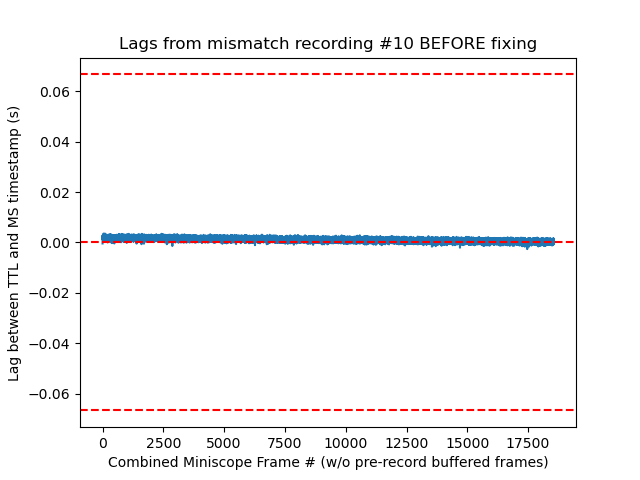

In [28]:
# Plot differences between timestamps and overlay miniscope sampling rate intervals to identify missing frames!
# Every time it jumps a box below you have a missing frame
%matplotlib widget
_, ax = plt.subplots()
ax.plot(diffs)
for sr_interval in np.arange(np.floor(np.min(diffs) / sr_spec), np.ceil(np.max(diffs) / sr_spec) + 1, 1):
    ax.axhline(sr_interval*sr_spec, color='r', linestyle='--')

drop_bool = np.abs(np.diff(diffs)) > sr_spec
drop_inds = np.where(drop_bool)[0]
ax.plot(drop_inds, diffs[:-1][drop_inds + 1], 'g*')
ax.set_ylabel("Lag between TTL and MS timestamp (s)")
ax.set_xlabel("Combined Miniscope Frame # (w/o pre-record buffered frames)")
ax.set_title(f"Lags from mismatch recording #{mismatch_rec} BEFORE fixing")

print(f"Approximate dropped frame locations at {drop_inds}")

Text(0.5, 1.0, 'Lags from mismatch recording #10 after fixing')

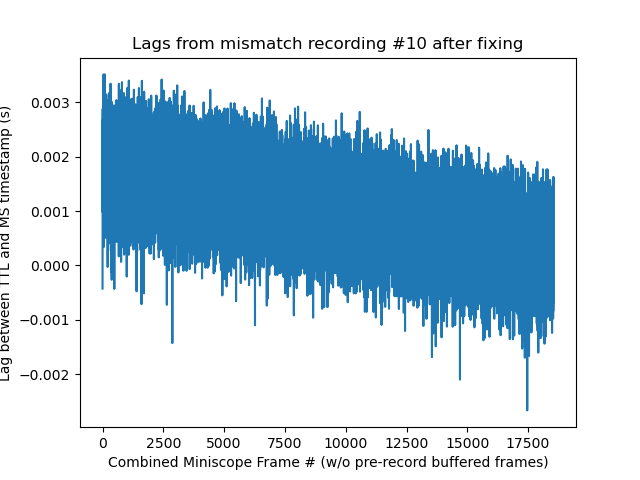

In [33]:
# Now play around below to identify indices to drop - should have everything around the same time difference
dropped_inds = [18543]
ttl_clipped = ttl_mismatch.drop(index=dropped_inds)
diffs_fixed = ttl_clipped["ttl_sec_from_eeg_start"].values - ms_ts_mismatch["Timestamps"].values
_, ax = plt.subplots()
ax.plot(diffs_fixed)
ax.set_ylabel("Lag between TTL and MS timestamp (s)")
ax.set_xlabel("Combined Miniscope Frame # (w/o pre-record buffered frames)")
ax.set_title(f"Lags from mismatch recording #{mismatch_rec} after fixing")

In [34]:
# Add in dropped frame info to aligned ttl DataFrame
dropped_bool = np.isin(rec_ttl_align_df.index, dropped_inds) & (rec_ttl_align_df.Recording == mismatch_rec)
rec_ttl_align_df["Dropped_by_ms"] = dropped_bool
rec_ttl_align_df

,ttl_sec_from_eeg_start,Recording,Dropped_by_ms
0,2.743865,0,False
1,2.813531,0,False
2,2.878631,0,False
3,2.946131,0,False
4,3.014364,0,False
...,...,...,...
8013,9840.188469,13,False
8014,9840.255469,13,False
8015,9840.323903,13,False
8016,9840.390236,13,False


### Will need to delete any MS frames happening between recordings if that occurs here

Text(0.5, 0, 'Combined Miniscope Frame # (w/o pre-record buffered frames)')

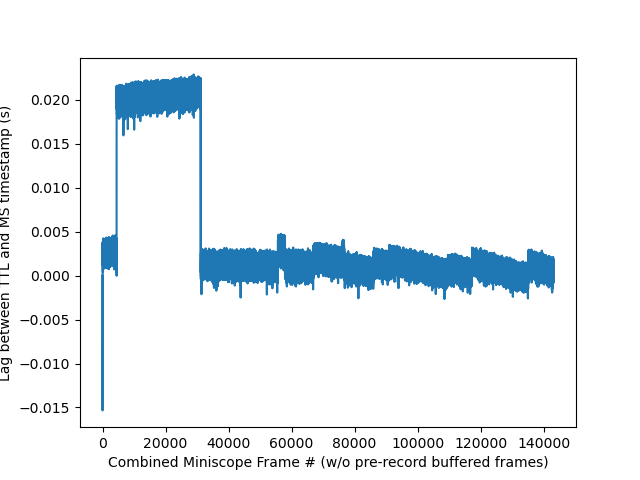

In [36]:
# Check full alignment now! Should show mostly very small differences between frame times with only periodic blips where one frame
# was captured with some jitter.
full_diffs = rec_ttl_align_df[~rec_ttl_align_df.Dropped_by_ms]["ttl_sec_from_eeg_start"].values - ms_ts_align_df[~ms_ts_align_df.Pre_rec_buffer]['Timestamps'].values

_, ax = plt.subplots()
ax.plot(full_diffs)
ax.set_ylabel("Lag between TTL and MS timestamp (s)")
ax.set_xlabel("Combined Miniscope Frame # (w/o pre-record buffered frames)")

## Save aligned timing dataframes! Dump TTL timing into ms dataframe.
Can either use ms data directly OR TTL timing later during analysis.

In [37]:
# Insert TTL times into aligned miniscope timestamp dataframe
ms_ts_align_df.loc[~ms_ts_align_df.Pre_rec_buffer & ms_ts_align_df.Matching_TTL, "TTL_time"] = rec_ttl_align_df[~rec_ttl_align_df.Dropped_by_ms]["ttl_sec_from_eeg_start"].values

# Flag all frames with sufficient LED power (only those are including in final C.npy Minian output)
ms_ts_align_df.loc[~ms_ts_align_df.Corrupt, "okLEDpower"] = good_frames_bool

# Save to .npy file and/or csv file
np.save(sess.filePrefix.with_suffix(".ms_times_aligned.npy"), ms_ts_align_df, allow_pickle=True)
ms_ts_align_df.to_csv(sess.filePrefix.with_suffix(".ms_times_aligned.csv"))
ms_ts_align_df

,Timestamps,Recording,Corrupt,Pre_rec_buffer,TTL_time,okLEDpower
-1,2.673867,0,False,True,NaN,False
0,2.743867,0,False,False,2.743865,False
1,2.828867,0,False,False,2.813531,False
2,2.877867,0,False,False,2.878631,False
3,2.943867,0,False,False,2.946131,False
...,...,...,...,...,...,...
8013,9840.188300,13,False,False,9840.188469,True
8014,9840.255300,13,False,False,9840.255469,True
8015,9840.323300,13,False,False,9840.323903,True
8016,9840.390300,13,False,False,9840.390236,True


# Save this notebook to working directory after you are done for reference

In [6]:
import ipynbname
import shutil
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

nb_copy_savename = sess.filePrefix.with_suffix(".miniscope_align.ipynb")
shutil.copy(str(nb_path), str(nb_copy_savename))

'/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/Finn_psilocybin_denoised.miniscope_align.ipynb'